In [243]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from category_encoders import *
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split




In [217]:
data = pd.read_csv("parfumo_data.csv")
data = data.drop(['name'], axis=1)
data =data.dropna()


## Eval Accords

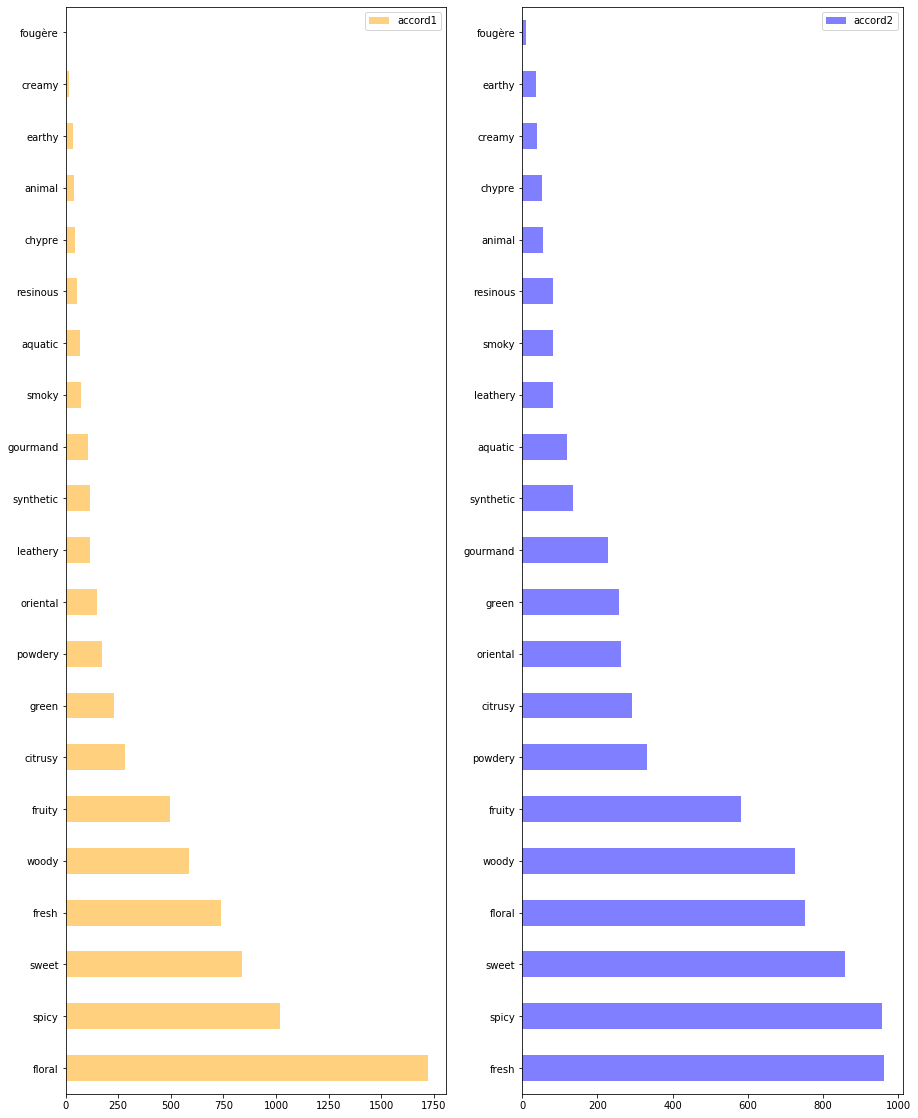

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,20))
data["accord1"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="orange", ax=axes[0])
data["accord2"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="blue", ax=axes[1])


In [203]:
print(data['accord1'].value_counts())

floral       1722
spicy        1019
sweet         839
fresh         741
woody         585
fruity        494
citrusy       284
green         230
powdery       173
oriental      147
leathery      117
synthetic     116
gourmand      108
smoky          73
aquatic        68
resinous       53
chypre         46
animal         38
earthy         34
creamy         14
fougère         4
Name: accord1, dtype: int64


In [204]:
print(data['accord2'].value_counts())

fresh        963
spicy        956
sweet        857
floral       753
woody        725
fruity       582
powdery      333
citrusy      291
oriental     262
green        258
gourmand     228
synthetic    136
aquatic      118
leathery      83
smoky         82
resinous      81
animal        56
chypre        53
creamy        40
earthy        38
fougère       10
Name: accord2, dtype: int64


# Removing Outliers

## Remove Outliers from Longevity

-0.1221979289321172


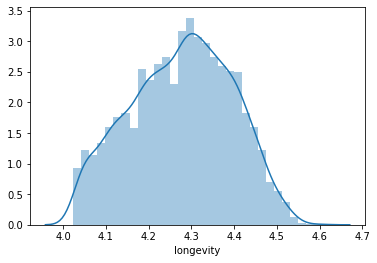

In [223]:
i = 'longevity'

new_longevity = data[i].where(data[i] < data[i].quantile(.90))
new_longevity = data[i].where(data[i] > data[i].quantile(.10))
# 
log_longevity = np.log(new_longevity)
print(log_longevity.skew())
sns.distplot(log_longevity)

data[i] = log_longevity

## Remove Outliers from Sillage

0       76.5000
1       67.8261
2       76.5217
4       63.0435
5       67.6471
         ...   
8456    79.7959
8457    80.9302
8458    73.0233
8459    74.3902
8460    58.0645
Name: sillage, Length: 6905, dtype: float64

-0.10595450521382904


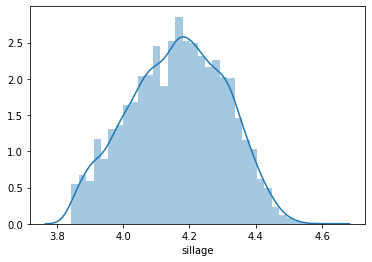

In [224]:
i = 'sillage'
sill_no_outliers = data[i].where(data[i] < data[i].quantile(.95))
sill_no_outliers = data[i].where(data[i] > data[i].quantile(.05))

display(sill_no_outliers)

log_sillage = np.log(sill_no_outliers)
print(log_sillage.skew())
sns.distplot(log_sillage)

data[i] = log_sillage

In [227]:
# Drop NA's from removing outliers
data.dropna(inplace=True)
display(data)

,brand,year,rating,votes,longevity,sillage,accord1,accord2
0,4160_Tuesdays,2013.0,76.7568,37.0,4.375757,4.337291,sweet,spicy
1,4160_Tuesdays,2015.0,81.5714,35.0,4.323029,4.216947,gourmand,sweet
2,4160_Tuesdays,2016.0,76.7742,31.0,4.429781,4.337574,fruity,floral
4,4160_Tuesdays,2013.0,72.9630,27.0,4.251596,4.143825,sweet,woody
5,4160_Tuesdays,2017.0,80.0000,20.0,4.374647,4.214304,spicy,woody
...,...,...,...,...,...,...,...,...
8456,Zoologist,2019.0,80.8491,53.0,4.443851,4.379472,aquatic,spicy
8457,Zoologist,2019.0,73.0769,52.0,4.457587,4.393587,green,spicy
8458,Zoologist,2017.0,75.0000,51.0,4.352526,4.290779,green,fruity
8459,Zoologist,2019.0,75.8163,49.0,4.403143,4.309324,floral,sweet


## Encode Categories

In [228]:
data['accord1'] = data['accord1'].astype('category')
data['accord2'] = data['accord2'].astype('category')
data['brand'] = data['brand'].astype('category')
data['year'] = data['year'].astype('category')

accord_cols=["accord1", "accord2"]
brand_cols = ['brand']
year_cols = ['year']

# Encode Accords
bin_enc = BinaryEncoder(cols=accord_cols).fit(data)
encoded = bin_enc.transform(data)

encoded_y = encoded.filter(['rating'])
encoded_x = encoded.drop(['rating'], axis=1)

# Encode the Year
targ_encoder = TargetEncoder(cols=year_cols).fit(encoded_x, encoded_y)
encoded_x = targ_encoder.transform(encoded_x)

# Encode brand name
targ_encoder2 = TargetEncoder(cols=brand_cols).fit(encoded_x, encoded_y)
encoded_x = targ_encoder2.transform(encoded_x)


In [258]:
y = encoded_y
X = encoded_x

display(y)
display(X)

,rating
0,76.7568
1,81.5714
2,76.7742
4,72.9630
5,80.0000
...,...
8456,80.8491
8457,73.0769
8458,75.0000
8459,75.8163


,brand,year,votes,longevity,sillage,accord1_0,accord1_1,accord1_2,accord1_3,accord1_4,accord1_5,accord2_0,accord2_1,accord2_2,accord2_3,accord2_4,accord2_5
0,74.389126,73.673437,37.0,4.375757,4.337291,0,1,0,0,1,1,0,1,0,0,1,0
1,74.389126,74.882702,35.0,4.323029,4.216947,0,0,1,0,1,1,0,1,0,0,1,1
2,74.389126,75.602973,31.0,4.429781,4.337574,0,0,1,0,1,0,0,0,0,1,1,1
4,74.389126,73.673437,27.0,4.251596,4.143825,0,1,0,0,1,1,0,1,0,1,0,1
5,74.389126,75.746077,20.0,4.374647,4.214304,0,1,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,74.080830,74.679638,53.0,4.443851,4.379472,0,0,0,0,1,0,0,1,0,0,1,0
8457,74.080830,74.679638,52.0,4.457587,4.393587,0,0,1,1,0,0,0,1,0,0,1,0
8458,74.080830,75.746077,51.0,4.352526,4.290779,0,0,1,1,0,0,0,0,1,0,1,0
8459,74.080830,74.679638,49.0,4.403143,4.309324,0,0,0,1,1,1,0,1,0,0,1,1


## Split Data

In [230]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=2)


## Trial 1 XGBoost

In [231]:
model = xgb.XGBRegressor(max_depth=7,
                        objective="reg:squarederror", 
                        learning_rate=0.05, 
                        subsample=0.9, 
                        colsample_bylevel=0.5,
                        reg_alpha=0.75, 
                        reg_lambda=0.5,
                        n_estimators=1000)  

In [248]:
folds = KFold(n_splits=10, random_state=5)
results = cross_val_score(model, x_train, y_train, cv=folds, scoring='neg_mean_squared_error')

print(results)

[-29.96254927 -28.70303842 -24.63107155 -28.27391442 -30.68213053
 -25.5142592  -27.82884032 -30.47651958 -29.64965595 -29.94935272]


In [251]:
rmse = np.sqrt(results * -1)
print(rmse)

[5.47380574 5.35752167 4.96297003 5.31732211 5.53914529 5.05116414
 5.27530476 5.52055428 5.44514976 5.47260018]


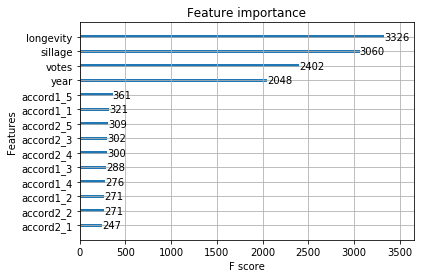

In [152]:
from xgboost import plot_importance
model.fit(x_train, y_train)

plot_importance(model)

## Trial 2 Elastic Net

In [252]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha = 0.1)

In [253]:
enet_results = cross_val_score(enet, x_train, y_train, cv=folds, scoring="neg_mean_squared_error")

In [256]:
print(enet_results)
enet_rmse = np.sqrt(enet_results * -1)
print(enet_rmse)

[-32.16921192 -32.93692696 -26.79798704 -32.47179685 -31.47442336
 -27.35266117 -31.71988929 -34.16651472 -31.58542769 -32.90271591]
[5.67179089 5.73907022 5.17667722 5.69840301 5.61020707 5.22997717
 5.63204131 5.84521297 5.62009143 5.7360889 ]
